# ▂▂▂▂▂▂▂▂▂▂▂▂

# S1. Overview

This Notebook calculates singular values for all of the attention heads in models using the DeepSeek-V3 architecture (DeepSeek-V3, DeepSeek-R1, Kimi-K2, ...)

The resulting data structure is designed to be used by a separate plotting notebook, [here]() TODO.

Some of the plots are used in my blog post, [here](https://mccormickml.com/2025/07/28/output-latent-spaces-in-multihead-attention/).


I give some context / introduction to SVD analysis in my blog post (again, [here](https://mccormickml.com/2025/07/28/output-latent-spaces-in-multihead-attention/)) and am working on a more in-depth tutorial.

All of the analysis is based on the singular values of these weight matrices, so I start by computing and saving all of those (in this notebook).

I've pre-computed singular values for several models, so if you want to play with them yourself you can skip the whole process of retrieving the V3 weights and running SVD.

## 1.1. Theory

### Lower Effective Rank of Fused Matrices

We're looking at the fused forms of the attention matrices because the fused form often has a lower effective rank than the individual heads.

How does that happen? This deserves its own blog post, but I'll try to give a quick overview.

Let's use the dimensions of GPT-2 as an example. It has an embedding size (a.k.a. the size of its "residual stream") of 768, and a head size of 64.

The way I would typically think about the respective roles of a given Value head and Output head pair is that the 64 vectors in the Value head dictate the directions in the residual stream it can read from, and for the Output head they determine the directions it can write to.

In order to make sense of this lower rank phenomemom, it helps to think instead of the Value head writing into a 64 dimensional space and the Output head reading from a 64 dimensional space.

What's a little odd about this is that they both independently define that 64-dim space.

In the residual stream, I think it makes intuitive sense that the heads might want to read and write to different parts of it.

But in this 64-dim inner space, if the Value head and Output head don't "agree" on the definition of the space, then we get lower effective rank heads and therefore poorer use of the available parameters.

There are two types of scenarios where this happens:


**Dragged Down by the Lower of the Two**

The first is where, say, the Output head has full rank, but the Value head has relatively low rank, and their fused form has the same rank as the Value head.

You can see this in many of the early layers. One strong example is layer 8 of DeepSeek-R1, below.

<img src='https://lh3.googleusercontent.com/d/1A4whsqz0PRgxR0fa3n73XTpSR0XfwUo9' alt='Plot of the effective ranks of the Value, Output, and fused VO matrix in DeepSeek-R1 showing the combined effective rank being dragged down by the value matrix' width='900' />


This means that the Output head is capable of reading from a larger space than the Value head can actually write to, but that they are at least in agreement on the space in the sense that where the Value head can write is (largely) encompassed by what the Output head can read.

In this case, the Output head has more parameters than it needs.


**High-Rank but Misaligned**

The second situation I find more interesting. Let's say the Value and Output heads are both showing high effective rank, but their fused form has much lower rank. What happened?

The first few layers seem to have the most examples of this. Below is layer 2 of DeepSeek-R1.


<img src='https://lh3.googleusercontent.com/d/1iBfzQ1qLt6p5jhHMGaBtD3vob3RAxTZh' alt='Plot of the effective ranks of the Value, Output, and fused VO matrix in DeepSeek-R1 layer 2 showing the combined effective rank being much lower than either of the v or o separately' width='900' />

This indicates that the heads aren't aligned on their definition of the 64-dim space that they communicate through.

The Value head is writing strongly to directions that the Output head isn't strongly reading from.

**Similar Outcomes**

Both scenarios have the same effect--there's a smaller amount of overlap between the Value and Output head. So perhaps they're no different, and the second scenario is just a different way of arriving at the first.

Just speculation, but I wonder if the second scenario occurs when the model learns a behavior in the head earlier on in training, resulting in a pair of high-rank heads, but then decides to suppress it later, and rotates the spaces out of alignment?



**High Rank Heads**

I think it's also worth noting that in many cases (most, really!) the Value and Output heads in a pair are both high rank, and so is their fused form.

The plots usually look more like this one--it's the early layers where we see most of the low effective rank.

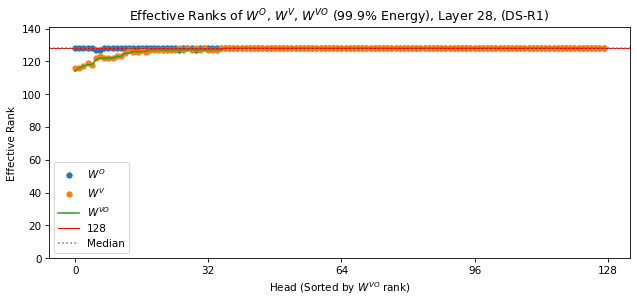

When the effective ranks are both high and so is the fused form, I think this implies that they've both landed on a well-aligned 64-dimensional space.


### Miscellaneous

**Folding RMSNorm Weight Vectors**

The RMSNorms are a non-linear operation, but they do contain a weight vector on the end which can be folded into the matrix following the norm.

There's a flag for whether to do this or not.

For my analysis, I did fold them in, since there may be additional structure from the combination which could further reduce the effective rank of the projection matrix.



**Spectral Normalization**

This is something that needs elaborating on. Prior to stacking the matrices, we're dividing each one by it's largest singular value.

This has the effect of normalizing the amplitude of the heads so that any "loud" ones don't dominate the analysis.

It makes the results more about overlap in the directions, which is probably a good thing for identifying shared subspaces, which was the original point of this analysis.

But it is also likely raises the effective ranks, so probably deserves at least calling out somewhere.

### Fusing RoPE Heads

Heads which receive position information can't be fused in quite the same way.

Their interaction is not as simple as $x W^Q_i {W^K_i}^\top x^\top$.

The correct equation needs to include the RoPE embeddings in between, which are dependent on the position offset $\Delta$ between the two tokens you're comparining.

So now the fused matrix has this extra parameter to incorporate:

$$\,W^{QK}_i(\Delta)=W^Q_i\, R(\Delta)\,{W^K_i}^{\!\top}$$

and we can't trivially fuse it like we have been.

However, if we choose a particular offset, e.g., 128, then we _can_ fuse them and look at the matrix at least within that context.

What's great about MLA, though, is that it doesn't apply RoPE to most of its query and key head dimensions! That's why we're able to calculate their fused form in this Notebook.

## 1.2. Practical Details

**File Management**

DeepSeek-V3/R1 and Kimi-K2 are enormous models, something like 650B parameters for DS-V3 and 1 Trillion for Kimi-K2! Even though the weights have been quantized to 8-bits, they're still too big to fit on the 250GB hard drive of a Colab instance!

For smaller models, I would simply use the `from_pretrained` function in HuggingFace `transformers` to retrieve and load the model weights.

Instead, we need to carefully manage the disk space and download and delete files as needed. The functions for this are in the "Retrieval Functions" section.

**Copmute Requirements**

Since we're looking at the matrices one at a time, the free T4 instances have enough GPU memory to perform the task. They seem to have a slower connection to the huggingface models repo, though, which is an important factor here. If you have Colab Pro, the L4 may be a better choice.


**Reference**

I went off of my commented version of MLA (TODO - share) to figure out / verify I was accessing the parameter shapes correctly.

Note that there are two implementations--one from DeepSeek and one from HuggingFace. The parameter names come from the HuggingFace version, but my commented version is the DeepSeek one.

**Data Structure**

Specific weight matrices are indexed using a letter code:

```python
# Symbols for all of the weight matrices
W_names = [
    'Q', 'K', 'V', 'O', # Attention matrices
    'QK', 'KQ', 'VO',   # Fused matrices
    'KVA', 'QA',        # Latent projections
    'KVA_pe', 'Q_pe'    # Position information (RoPE) heads.
]
```

Then the singular values are stored in dictionaries:

```python
# Subspace matrices are one per-layer
S_subspaces = {}     # S_subspaces[layer_i][W_name] --> List of sigmas

# Calculated for each head independently (i.e., if DS-V3 has 128 heads
# in a layer, so there are 128 sets of singular values)
S_heads = {}         #     S_heads[layer_i][W_name][head_i] --> List of sigmas

# For a particular parameter, stack all of the heads to find a common
# subspace. One stack per layer.
S_stacked_heads = {} # S_stacked_heads[layer_i][W_name] --> List of sigmas
```

# ▂▂▂▂▂▂▂▂▂▂▂▂

# S2. Calculate Singular Values

## 2.1. Choose Model

This section handles defining some global variables depending on what model you want to look at. Set the `model_name` variable below and it will initialize the right values.

Note that I only have the pre-computed values uploaded for one model currently, DeepSeek-R1.

In [ ]:
# ==============================
#   Choose a Model To Look At
# ==============================

# Choose the model you want to look at:
#   Options: "DS-V3", "DS-V3-base", "DS-R1", "K2", "K2-base"
model_name = "DS-V3-base"

# DeepSeek-V3, Instruction-tuned
if model_name == "DS-V3":
    singular_vals_file = "ds-v3_singular_values.pkl"
    num_layers = 62   # includes MTP head
    num_heads = 128

    vals_available = False

    repo_id = "deepseek-ai/DeepSeek-V3"
    safetensors_index_filename = "inference/model.safetensors.index.json"

# DeepSeek-V3 Base model
elif model_name == "DS-V3-base":
    singular_vals_file = "ds-v3-base_singular_values.pkl"
    num_layers = 62
    num_heads = 128

    vals_available = False

    repo_id = "deepseek-ai/DeepSeek-V3-Base"
    safetensors_index_filename = "model.safetensors.index.json"

# DeepSeek-R1 Reasoning model
elif model_name == "DS-R1":
    singular_vals_file = "ds-r1_singular_values.pkl"
    num_layers = 62
    num_heads = 128

    vals_available = True

    repo_id = "deepseek-ai/DeepSeek-R1"
    safetensors_index_filename = "model.safetensors.index.json"

# Kimi-K2 Instruction-tuned
elif model_name == "K2":
    singular_vals_file = "k2_singular_values.pkl"
    num_layers = 61
    num_heads = 64

    vals_available = False

    repo_id = "moonshotai/Kimi-K2-Instruct"
    safetensors_index_filename = "model.safetensors.index.json"

# Kimi-K2 Base model
elif model_name == "K2-base":
    singular_vals_file = "k2-base_singular_values.pkl"

    num_layers = 61
    num_heads = 64

    vals_available = False

    repo_id = "moonshotai/Kimi-K2-Base"
    safetensors_index_filename = "model.safetensors.index.json"

else:
    raise ValueError(f"Unknown model: {model_name}")

print(f"Model: {model_name} | Layers: {num_layers} | Heads: {num_heads}")
print(f"Singular values file: {singular_vals_file}")


Model: DS-V3-base | Layers: 62 | Heads: 128
Singular values file: ds-v3-base_singular_values.pkl


Retrieve the index file from the huggingface datasets repository for the model. This maps the parameter names to the name of the safetensor file that contains it.

In [ ]:
import json
from huggingface_hub import hf_hub_download

# Download the safetensors index json for the selected model.
json_path = hf_hub_download(
    repo_id=repo_id,
    filename=safetensors_index_filename,
    local_dir=".",
    repo_type="model",   # these repos are model repos
)

# Load JSON as "file_mappings"
with open(json_path) as f:
    file_mappings = json.load(f)


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Calculating the singular values is heavy work, I'd definitely recommend a GPU.

In [ ]:
# Device for SVD computation
device = "cuda"

## 2.2. Retrieval Functions

**Dequant Function**

The DS-V3 architecture stores most of its weight using 8-bit quantization, so we need to dequantize the weights first.

I had GPT write the below function for me based on code from the HuggingFace GitHub in the files:

* [fp8_cast_bf16.py](https://huggingface.co/deepseek-ai/DeepSeek-V3/raw/main/inference/fp8_cast_bf16.py)
* [kernel.py](https://huggingface.co/deepseek-ai/DeepSeek-V3/raw/main/inference/kernel.py)


In [ ]:
import torch

def dequant_fp8_blockwise(x: torch.Tensor, scale_inv: torch.Tensor, block_size: int = 128) -> torch.Tensor:
    """
    Fallback for dequantizing FP8 weights without using Triton.
    Assumes x is [M, N], scale_inv is [M // B, N // B]
    """
    M, N = x.shape
    M_blocks = M // block_size
    N_blocks = N // block_size
    y = torch.empty(M, N, dtype=torch.float32)

    for i in range(M_blocks):
        for j in range(N_blocks):
            row_start = i * block_size
            row_end = row_start + block_size
            col_start = j * block_size
            col_end = col_start + block_size

            scale = scale_inv[i, j]
            block = x[row_start:row_end, col_start:col_end].to(torch.float32)
            y[row_start:row_end, col_start:col_end] = block * scale

    return y


**Get Disk Usage**

We need to monitor our disk usage and delete files as needed--this function retrieves the current disk usage for the Colab instance.

In [ ]:
# To get the disk usage in human-readable format
!df -h /

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   39G  197G  17% /


In [ ]:
# Run "!df -h /" and parse the output into CSV
import csv
import subprocess
import pandas as pd

def get_disk_usage():
    """
    Returns the current disk usage percentage as an integer.
    """

    result = subprocess.run(["df", "-h", "/"], capture_output=True, text=True)

    # Output looks like:
    #    Filesystem      Size  Used Avail Use% Mounted on
    #    overlay         226G   47G  180G  21% /
    #

    lines = result.stdout.strip().split("\n")
    headers = lines[0].split()

    # Remove the last header
    headers = headers[:-1]

    data = [line.split() for line in lines[1:]]

    # Load into a dataframe
    df = pd.DataFrame(data, columns=headers)
    #display(df)

    value = df.loc[0, "Use%"]

    # Parse the percentage (e.g., "21%") into an integer
    usage = int(value[:-1])
    #print(usage)

    return usage


In [ ]:
import re

def extract_file_number(filename):
    """Extract integer file number from a safetensors filename like
    model-00040-of-000163.safetensors"""

    match = re.search(r'model-(\d+)-of-\d+\.safetensors', filename)

    assert match is not None, "Invalid filename format"

    return int(match.group(1))

In [ ]:
import os

cache_dir = "./fp8_cache/"

def free_up_space(current_filename):
    """
    Frees disk space by identifying which file we're least likely to need next
    (based on the assumption that it's whatever file number if furthest away)
    and deleting it.
    """

    # Get the file number from the filename.
    current_number = extract_file_number(current_filename)

    # List all cached safetensors files and find the one furthest from current
    candidate_files = [
        f for f in os.listdir(cache_dir) if f.startswith("model") and f.endswith(".safetensors")
    ]

    furthest_file = None
    max_distance = -1

    # For each file,
    for f in candidate_files:

        # Get the filenumber
        file_number = extract_file_number(f)

        # Check if it's the furthest away.
        distance = abs(current_number - file_number)
        if distance > max_distance:
            max_distance = distance
            furthest_file = f


    print(f"  ↳ Deleting {furthest_file}")

    os.remove(os.path.join(cache_dir, furthest_file))


**`retrieve_and_dequant_weight`**


This function implements the overall process for retrieving the specified parameter from DeepSeek-V3.

It manages disk usage by deleting files as needed to free up space for new ones.


In [ ]:
from huggingface_hub import hf_hub_download
from safetensors.torch import safe_open


def retrieve_and_dequant_weight(param_name, scale_name=None, dequant=True):

    #print(f"Retrieveing {param_name}...")

    # Look up the filename for the requested parameter.
    weight_filename = file_mappings["weight_map"][param_name]

    # First, check if the disk is getting full, and if so,
    # delete an existing safetensors file
    usage = get_disk_usage()

    # If the use is over 90%...
    if usage > 90:
        #print(f"  ↳ Disk usage is {usage}%")

        # Delete the furthest away file from the requested one.
        free_up_space(weight_filename)

    # Use huggingfaces download function to retrieve it.
    weight_path = hf_hub_download(
        repo_id=repo_id,
        filename=weight_filename,
        local_dir=cache_dir
    )

    # Use `safe_open` from safetensors to get the parameter from the file.
    with safe_open(weight_path, framework="pt", device=device) as f:
        W = f.get_tensor(param_name)

    # Dequantize the weights, if needed.
    # (The RMSNorm weight vectors are already 16-bit)
    if dequant:

        # Load the S_inv parameter which contains the scaling factors to
        # dequantize the weights.

        # Note that sometimes this parameter crosses a file boundary, and we
        # will need to load a separate file.
        scale_filename = file_mappings["weight_map"][scale_name]

        if scale_filename != weight_filename:
            #print(f"  ↳ Loading scale tensor from separate file.")
            pass

        # Downloads the file if needed and gets the path to it.
        # The earlier disk usage check should have freed up plenty of space if
        # needed.
        scale_path = hf_hub_download(
            repo_id=repo_id,
            filename=scale_filename,
            local_dir=cache_dir)

        # Open with safetens
        with safe_open(scale_path, framework="pt", device=device) as f:
            S_inv = f.get_tensor(scale_name)

        # Dequantize
        W = dequant_fp8_blockwise(W.cpu(), S_inv.cpu()).to("cuda")

        #print(f"  ↳ Dequantized shape: {W.shape}")

    else:
        #print(f"  ↳ W shape: {W.shape}")
        pass

    return W


**Effective Rank at a Given Error**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_rank_for_error_threshold(S_values, error_threshold):
    """
    Calculates the minimum rank required to keep reconstruction error below a threshold.

    Args:
        S_values (np.array): A 1D array of singular values, sorted descending.
        error_threshold (float): The maximum allowed fraction of energy loss
                                 (e.g., 0.01 for 1% loss).

    Returns:
        int: The required rank.
    """
    # Calculate the energy (squared singular values)
    energy = S_values**2
    total_energy = np.sum(energy)

    # The reconstruction error is the fraction of energy lost.
    # We calculate the cumulative energy kept, and subtract from 1.
    cumulative_energy_kept = np.cumsum(energy)
    fraction_of_energy_lost = 1.0 - (cumulative_energy_kept / total_energy)

    # Find the first rank where the error is at or below the threshold.
    # np.where returns a tuple of arrays; we need the first element of the first array.
    valid_ranks = np.where(fraction_of_energy_lost <= error_threshold)[0]

    if len(valid_ranks) == 0:
        # If no rank satisfies the threshold, it means we need all of them.
        return len(S_values)

    # Add 1 because rank is 1-based, index is 0-based.
    required_rank = valid_ranks[0] + 1
    return required_rank


**Sizes and Shapes**

In [ ]:
import torch

def format_size(num: int) -> str:
    """Return a human readable string for the given integer."""
    suffixes = [" ", "K", "M", "B"]
    base = 1024
    for suffix in suffixes:
        if abs(num) < base:
            if num % 1 != 0:
                return f"{num:.2f}{suffix}"
            else:
                return f"{num:.0f}{suffix}"
        num /= base
    if num % 1 != 0:
        return f"{num:.2f}T"
    return f"{num:.0f}T"

def format_shape(shape: torch.Size) -> str:
    """Return a human readable string for the given shape."""


    # Working backwards, delete any dimensions that are size 1.
    for i in range(len(shape) - 1, -1, -1):
        if shape[i] == 1:
            del shape[i]

    if len(shape) == 1:
        shape_str = "{:>4,} x {:<4}".format(shape[0], "-")
    elif len(shape) == 2:
        shape_str = "{:>4,} x {:<4,}".format(shape[0], shape[1])
    elif len(shape) == 3:
        shape_str = "{:>4,} x {:,} x {:<4}".format(shape[0], shape[1], shape[2])
    elif len(shape) == 4:
        shape_str = "{:>4,} x {:,} x {:,} x {:<4}".format(
            shape[0], shape[1], shape[2], shape[3]
        )
    else:
        print("Unexpected: ", shape)

    return shape_str



## 2.3. Resume From Partial

As a simple save-and-resume mechanic, the current results are pickled at the end of each layer. If something happens, you can reload from the pickle file.

In [ ]:
# Set to True to load from an existing file.
resume = True

# The filename to store the data in was chosen up in the models section, but
# you can also overwrite it here if you want.
#singular_vals_file = "./ds-v3-base_singular_values.pkl"

# If we're resuming from an existing file,
if resume:
    # Load the dictionaries from the pickle file.
    with open(singular_vals_file, "rb") as f:
        S_subspaces, S_heads, S_stacked_heads = pickle.load(f)

    # Set the start layer based on how many layers were completed.
    start_layer = len(S_subspaces)

# Otherwise, for a fresh run,
else:
    # Initialize the empty dictionaries.
    S_subspaces = {} # S_subspaces[layer_i][W_name] --> List of sigmas
    S_heads = {}     # S_heads[layer_i][W_name][head_i] --> List of sigmas
    S_stacked_heads = {} # S_stacked_heads[layer_i][W_name] --> List of sigmas

    start_layer = 0



**Google Drive backups**

If you're running this on Colab, there's always the potential you'll get disconnected.

After processing a layer, there's the option to copy the updated pickle file to your Google Drive so you don't lose it.

In [ ]:
# Set to True to make a backup on Google Drive of the pickle file after
# completing each layer.
backup_to_gdrive = True

if backup_to_gdrive:
    # Mount Google Drive.
    from google.colab import drive
    drive.mount('/content/drive')

    # Specify the file path for the backup copy.
    backup_file = f"/content/drive/MyDrive/{singular_vals_file}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.4. Analysis Loop

Loop through the layers and compute all of the singular values!

In [ ]:
# Import for reporting elapsed time
import time

import re

# For saving sigma values to disk.
import pickle

fold_norms = True

# Symbols for all of the weight matrices
W_names = [
    'Q', 'K', 'V', 'O', # Attention matrices
    'QK', 'VO',         # Fused matrices
    'KVA', 'QA',        # Latent projections
    'KVA_pe', 'Q_pe'    # Position information (RoPE) heads.
]

# For clearer indexing.
final_layer = num_layers - 1

# Examples:
#   To retrieve the singular values for all W^O heads in layer_i:
#     S_stacked_heads[layer_i]['O']

t0 = time.time()

# For each layer in the model...
for layer_i in range(start_layer, num_layers):

    # Holds the shared subspace weight matrices KV, QA, and KVA_pe for this
    # layer. (Note - KVA_pe is really just a single k_pe head)
    subspace_ws = {}

    # Holds the tensors for the attention heads in this layer.
    head_ws = {}

    # Create empty dictionaries
    S_subspaces[layer_i] = {}
    S_heads[layer_i] = {}
    S_stacked_heads[layer_i] = {}

    print("\n--------")
    print(f"Layer {layer_i}")
    print("--------\n")

    # Print elapsed time in minutes
    print(f"Elapsed: {(time.time() - t0)/60:.2f} minutes")

    # ======== Attention Input Norm ========
    # Retrieve the input layer norm in case we want to fold it into the
    # weights.
    if fold_norms:
        matrix_name = "input_layernorm"
        param_name = f"model.layers.{layer_i}.input_layernorm.weight"

        # Retrieve the layernorm on the input to attention.
        # It's length 7168, and type bfloat16.
        input_norm_weight = retrieve_and_dequant_weight(
            param_name,
            "", # No scale_inv parameter.
            dequant=False
        )

        # Cast to Float
        input_norm_weight = input_norm_weight.float()

    # ======== Query Subspace Projection =========

    param_name = f"model.layers.{layer_i}.self_attn.q_a_proj.weight"
    scale_name = f"{param_name}_scale_inv"

    # Shape: 7168, 1536
    W_qa = retrieve_and_dequant_weight(
        param_name,
        scale_name,
        dequant=True
    )

    if fold_norms:
        # input_norm_weight is length 7168
        # W_QA is 1536, 7168

        # Fold the input RMSNorm into the query latent projection, W_qa
        W_qa = W_qa * input_norm_weight.unsqueeze(0)

    # Store the query latent projection for the current layer.
    subspace_ws['QA'] = W_qa

    # ======== Queries - RoPE and Non-RoPE =========
    matrix_name = "q_b_proj"
    param_name = f"model.layers.{layer_i}.self_attn.{matrix_name}.weight"
    scale_name = f"{param_name}_scale_inv"

    # W.shape: 24576, 1536
    W = retrieve_and_dequant_weight(
        param_name,
        scale_name,
        dequant = True
    )

    # Retrieve the query subspace layernorm and fold it
    # into the query projection.
    if fold_norms:
        if (layer_i == final_layer) or (layer_i == 0):
            print("    Folding in query subspace layernorm")

        matrix_name = "q_a_layernorm"
        param_name = f"model.layers.{layer_i}.self_attn.{matrix_name}.weight"

        # The layernorm weight is type bfloat16 and doesn't need to be dequantized.
        # There is no bias term on the RMSNorms.
        q_norm_weight = retrieve_and_dequant_weight(
            param_name,
            "", # No scale needed
            dequant=False
        )

        # Cast to float
        q_norm_weight = q_norm_weight.float()

        if (layer_i == final_layer) or (layer_i == 0):
            print("    input_norm_weight.shape:", input_norm_weight.shape)
            print("    q_norm_weight.shape:", q_norm_weight.shape)
            print("    Pre-fold, W_q.shape:", W.shape)

        # Fold into projection matrix
        # elementwise (1536,)
        # q_norm_weight is length 1536
        # W_Q is 24576, 1536

        W = W * q_norm_weight.unsqueeze(0)  # shape: [1, 1536]

        if (layer_i == final_layer) or (layer_i == 0):
            print("    Post-fold, W_q.shape:", W.shape)

    # First, reshape into heads.
    W = W.view(num_heads, 192, 1536)

    # Next, split the heads into the query heads and RoPE query heads
    W_q_heads, W_q_pe_heads = torch.split(W, [128, 64], dim=1)
    head_ws['Q'] = W_q_heads
    head_ws['Q_pe'] = W_q_pe_heads

    # ======== KV Subspace Projection =========

    param_name = f"model.layers.{layer_i}.self_attn.kv_a_proj_with_mqa.weight"
    scale_name = f"{param_name}_scale_inv"

    # Shape: 576, 7168
    W_kva_pe = retrieve_and_dequant_weight(
        param_name,
        scale_name,
        dequant=True
    )

    W_kva, W_pe = torch.split(W_kva_pe, [512, 64], dim=0)

    # Subspaces are one per layer
    subspace_ws['KVA'] = W_kva
    subspace_ws['KVA_pe'] = W_pe

    # ======== Keys and Values ========
    matrix_name = "kv_b_proj"
    param_name = f"model.layers.{layer_i}.self_attn.{matrix_name}.weight"
    scale_name = f"{param_name}_scale_inv"

    W = retrieve_and_dequant_weight(param_name, scale_name)

    # Retrieve the KV subspace layernorm and fold it
    # into the key and value projections.
    if fold_norms:

        matrix_name = "kv_a_layernorm"
        param_name = f"model.layers.{layer_i}.self_attn.{matrix_name}.weight"

        # The rmsnorm weight is type bfloat16 and doesn't need to be dequantized.
        # There is no bias term on the RMSNorms.
        kv_norm_weight = retrieve_and_dequant_weight(
            param_name,
            "", # No scale name needed
            dequant=False
        )

        # Cast to Float
        kv_norm_weight = kv_norm_weight.float()

        # kv_norm_weight is length 512
        # input_norm_weight is length 7168
        # W_KVA is 7168, 512
        # W_K is 16K, 512
        # W_V is 16K, 512

        # Fold into the Key and Value projection matrices
        W = W * kv_norm_weight.unsqueeze(0)

    #	32,768 × 512
    W_k, W_v = torch.split(W, [num_heads*128, num_heads*128], dim=0)
    # W_k is 16K x 512, W_v is 16k x 512

    # Separate into 64 or 128 heads
    head_ws['K'] = W_k.view(num_heads, 128, 512)
    head_ws['V'] = W_v.view(num_heads, 128, 512)

    # ======== Output ========
    matrix_name = "o_proj"
    param_name = f"model.layers.{layer_i}.self_attn.{matrix_name}.weight"
    scale_name = f"{param_name}_scale_inv"

    # Retrieve the combined output matrix, which has shape torch.Size([7168, 16384])
    W = retrieve_and_dequant_weight(param_name, scale_name)

    W_o = W

    # The heads are in the columns of W_O. There are 128 heads of size 128.
    head_ws["O"] = W_o.T.reshape(num_heads, 128, 7168)

    # Fuse the value and output heads
    # W_v is
    # head_ws["V"] is a tensor with shape (num_heads, head_dim, latent_dim)
    # W_o is
    # head_ws["O"] is a tensor with shape (num_heads, head_dim, model_dim)
    # We want W^VO, (num_heads, latent_dim, model_dim)
    head_ws["VO"] = torch.einsum('hdc,hdm->hcm', head_ws["V"], head_ws["O"])

    if False:
        print("\n-------- Fusion Shape --------")
        print("VOs shape:", head_ws["VO"].shape)
        print("Vs shape:", head_ws["V"].shape)
        print("Os shape:", head_ws["O"].shape)
        print("------------------------------\n")

    # Fuse the query and key heads.
    # W_k is (num_heads, 128, 512)
    # W_q is (num_heads, 128, 1536)
    head_ws["KQ"] = torch.einsum('hda,hdc->hca', head_ws['Q'], head_ws['K'])

    head_ws["QK"] = head_ws['KQ'].permute(0, 2, 1)

    # ======== Per-Head SVD ========

    print("\n  Inidividual heads...")

    # Compute singular values
    try:
        # For each weight matrix type,
        for W_name in ['Q', 'Q_pe', 'K', 'V', 'QK', 'KQ', 'O', 'VO']:

            S_heads[layer_i][W_name] = []

            # For each head in this layer,
            for head_i in range(num_heads):

                # Retrieve matrix `W_name` for head `head_i`
                head_W = head_ws[W_name][head_i]

                # Calculate its singular values
                S_head = torch.linalg.svdvals(head_W).cpu().numpy()

                # Store in our data structure.
                S_heads[layer_i][W_name].append(S_head)

    except Exception as e:
        print(f"  ✗ SVD failed: {e}")
        continue

    # ======== For Full Layer ========

    print("\n  Stacked heads...")

    # Finally, re-stack the heads.

    # For each per-head weight matrix type,
    for W_name in ['Q', 'Q_pe', 'K', 'V', 'QK', 'KQ', 'O', 'VO']:

        # Normalize each head using the "spectral norm"; divide
        # each head by its highest singular value.

        # For each head in this layer,
        for head_i in range(num_heads):

            # Retrieve its largest singular value (simply the first one).
            max_sigma = S_heads[layer_i][W_name][head_i][0]

            # Divide the head's matrix by its largest sigma value.
            head_ws[W_name][head_i] = head_ws[W_name][head_i] / max_sigma

        # Combine the first two dimensions, e.g.,
        # Reshape W^K from (num_heads, 128, 512) --> (num_heads*128, 512), or
        # Reshape W^VO from (num_heads, 512, 7168) --> (num_heads*512, 7168).
        W_stacked = head_ws[W_name].reshape(-1, head_ws[W_name].size(-1))

        print(f"\n---------- {W_name} ----------")
        print("Heads:", head_ws[W_name].shape, " → Stacked:", W_stacked.shape)

        try:
            # Compute the singular values for the stacked matrices of type
            # `W_name` for the current layer `layer_i`.
            S = torch.linalg.svdvals(W_stacked).cpu().numpy()

            # Store the result in our data structure.
            S_stacked_heads[layer_i][W_name] = S

            print(f"  Rank at 0.01% error: {get_rank_for_error_threshold(S, 0.01):,} / {len(S):,}")
            print("------------------------------\n")

        except Exception as e:
            print(f"  ✗ SVD failed: {e}")
            continue

    print("\n  Subspaces...")

    # For the per-layer matrices,
    for W_name in ['KVA', 'KVA_pe', 'QA']:
        print(f"\n---------- {W_name} ----------")
        print("  Shape:", subspace_ws[W_name].shape)
        try:
            # Compute the singular values for the projection matrix for this layer.
            S = torch.linalg.svdvals(subspace_ws[W_name]).cpu().numpy()
            S_subspaces[layer_i][W_name] = S

            print(f"  Rank at 0.01% error: {get_rank_for_error_threshold(S, 0.01):,} / {len(S):,}")
            print("------------------------------\n")


        except Exception as e:
            print(f"  ✗ SVD failed: {e}")
            continue

    # ======== Save Progress ========
    print("Saving progress...")

    # At the end of each layer, save our progress to disk with pickle.
    with open(singular_vals_file, "wb") as f:
        pickle.dump((S_subspaces, S_heads, S_stacked_heads), f)


    if backup_to_gdrive:
        # Copy to Google Drive to back up.
        import shutil
        import os

        # If the file already exists on google drive,
        if os.path.exists(backup_file):
            # Delete it
            os.remove(backup_file)

        # Copy to Google Drive to back up.
        shutil.copy(
            singular_vals_file,
            backup_file
        )

print("Done!")


--------
Layer 39
--------

Elapsed: 0.00 minutes
  ↳ Deleting model-00001-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,426 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,319 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- KQ ----------
Heads:

model-00106-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00004-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,428 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,298 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 498 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 496 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00109-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00006-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,384 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,249 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00111-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00007-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,431 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,297 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 496 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00114-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00009-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,438 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,306 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00117-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]


  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,107 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 998 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 492 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 491 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Size([65536, 1536])
  Rank at 0.01% error: 1,098 / 1

model-00119-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00012-of-000163.safetensors
  ↳ Deleting model-00013-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,402 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,275 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 496 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- KQ ----------
Heads: tor

model-00122-of-000163.safetensors:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

  ↳ Deleting model-00015-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,403 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,240 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 484 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 478 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 486 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00125-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00018-of-000163.safetensors


model-00123-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00021-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,371 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,248 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 487 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 488 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 488 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00128-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00023-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,339 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,139 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 498 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00131-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00026-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,382 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,229 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 498 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00133-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00029-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,390 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,195 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 491 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 492 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00136-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00031-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,265 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,141 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00139-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00034-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,277 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,108 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 492 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00141-of-000163.safetensors:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

  ↳ Deleting model-00035-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,233 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,067 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00144-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00037-of-000163.safetensors


model-00142-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00040-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,348 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,064 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 491 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 485 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00147-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00043-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,369 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,205 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 490 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 492 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00150-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00045-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,284 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,116 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00152-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00048-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,096 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 954 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 489 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 488 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 487 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Size(

model-00155-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00051-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 756 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 594 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 472 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 470 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 458 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Size([6

model-00158-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  ↳ Deleting model-00053-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,288 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,092 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 485 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 486 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 484 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Siz

model-00160-of-000163.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

  ↳ Deleting model-00056-of-000163.safetensors
  ↳ Deleting model-00057-of-000163.safetensors

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 755 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 551 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 478 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 475 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 470 / 512
------------------------------


---------- KQ ----------
Heads: torch.S

model-00163-of-000163.safetensors:   0%|          | 0.00/6.58G [00:00<?, ?B/s]

  ↳ Deleting model-00059-of-000163.safetensors
    Folding in query subspace layernorm
    input_norm_weight.shape: torch.Size([7168])
    q_norm_weight.shape: torch.Size([1536])
    Pre-fold, W_q.shape: torch.Size([24576, 1536])
    Post-fold, W_q.shape: torch.Size([24576, 1536])

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,411 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,200 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 493 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 494 / 512
------------------------------


---------- Q

# ▂▂▂▂▂▂▂▂▂▂▂▂

# Appendix

## Example Output

For DeepSeek-R1

```
--------
Layer 52
--------

Elapsed: 38.72 minutes
model-00139-of-000163.safetensors:   0%|          | 0.00/4.30G [00:00<?, ?B/s]

  Inidividual heads...

  Stacked heads...

---------- Q ----------
Heads: torch.Size([128, 128, 1536])  → Stacked: torch.Size([16384, 1536])
  Rank at 0.01% error: 1,277 / 1,536
------------------------------


---------- Q_pe ----------
Heads: torch.Size([128, 64, 1536])  → Stacked: torch.Size([8192, 1536])
  Rank at 0.01% error: 1,108 / 1,536
------------------------------


---------- K ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 497 / 512
------------------------------


---------- V ----------
Heads: torch.Size([128, 128, 512])  → Stacked: torch.Size([16384, 512])
  Rank at 0.01% error: 495 / 512
------------------------------


---------- QK ----------
Heads: torch.Size([128, 1536, 512])  → Stacked: torch.Size([196608, 512])
  Rank at 0.01% error: 492 / 512
------------------------------


---------- KQ ----------
Heads: torch.Size([128, 512, 1536])  → Stacked: torch.Size([65536, 1536])
  Rank at 0.01% error: 1,254 / 1,536
------------------------------


---------- O ----------
Heads: torch.Size([128, 128, 7168])  → Stacked: torch.Size([16384, 7168])
  Rank at 0.01% error: 6,134 / 7,168
------------------------------


---------- VO ----------
Heads: torch.Size([128, 512, 7168])  → Stacked: torch.Size([65536, 7168])
  Rank at 0.01% error: 5,897 / 7,168
------------------------------


  Subspaces...

---------- KVA ----------
  Shape: torch.Size([512, 7168])
  Rank at 0.01% error: 500 / 512
------------------------------


---------- KVA_pe ----------
  Shape: torch.Size([64, 7168])
  Rank at 0.01% error: 64 / 64
------------------------------


---------- QA ----------
  Shape: torch.Size([1536, 7168])
  Rank at 0.01% error: 1,329 / 1,536
------------------------------

Saving progress...
```